In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from types import SimpleNamespace
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")

In [50]:
brm_hourly = pd.read_csv("../generated/brm_hourly.csv")
frb_hourly = pd.read_csv("../generated/frb_hourly.csv")

In [51]:
def timedelta_to_hours(timedelta_array):
    return timedelta_array.map(lambda x: x / pd.Timedelta("1 hour"))

def add_weekday(frame):
    frame["day"] = pd.to_datetime(frame["day"])
    frame["weekday"] = frame["day"].map(lambda x: x.weekday())
    return frame

def regression(frame,frame_model):
    y = frame["trip_duration"]
    X = frame[["temperature","precipitation"]]
    frame_model.fit(X, y)
    predict = frame_model.predict(X)
    return predict

def plot_regression(X,y, predict):
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel("temperature in °C")
    plt.ylabel("trip duration in h")
    plt.plot(X, predict, c='C2')
    plt.legend(['Squared loss fit','Observed hours'])


def triple_split(X, y, train_size, validate_size):
    if (train_size+validate_size) <= 1:
        x_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=(1-train_size))
        x_validate, x_test, y_validate, y_test = train_test_split(x_tmp, y_tmp, test_size=(1-validate_size/(1-train_size)))
        return x_train, x_validate, x_test, y_train, y_validate, y_test

In [52]:
frb_hourly["trip_duration"] = timedelta_to_hours(frb_hourly["trip_duration"])
brm_hourly["trip_duration"] = timedelta_to_hours(brm_hourly["trip_duration"])


In [53]:
def linear_regression(input):
    model = LinearRegression()
    model.fit(input[0], input[2])
    predict = model.predict(input[1])
    y_pred = model.predict(input[0])
    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})


def polynomial_regression(input, degree):
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])
    model.fit(x_poly, input[2])

    predict = model.predict(x_poly_test)
    y_pred = model.predict(x_poly)
    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})


def ridge_regression(input, degree, alpha):
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])

    model = Ridge(alpha, normalize=True)
    model.fit(x_poly, input[2])
    predict = model.predict(x_poly_test)
    y_pred = model.predict(x_poly)

    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})


def lasso_regression(input, degree, alpha):
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])

    model = Lasso(alpha, normalize=True)
    model.fit(x_poly, input[2])
    predict = model.predict(x_poly_test)
    y_pred = model.predict(x_poly)

    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})


In [83]:
def test_regression_alpha(start, end, step_size, regression, split, degree=4):
    mse_array = []
    r2_array = []
    alpha_array = []
    
    best_alpha = 0

    alpha = start
    while alpha < end:
        obj = regression(split, degree, alpha)
        alpha_array.append(alpha)
        if len(r2_array) == 0 or obj.r2 > max(r2_array):
            best_alpha = alpha
        r2_array.append(obj.r2)
        mse_array.append(obj.mse)

        alpha += step_size
    
    plt.subplot(1,2,1)
    plt.plot(alpha_array, r2_array)
    plt.title("R^2")
    plt.xlabel("alpha")
    
    plt.subplot(1,2,2)
    plt.plot(alpha_array, mse_array)
    plt.title("MSE")
    plt.xlabel("alpha")
    
    plt.show()
    
    print("Best alpha: ", best_alpha)
    print("Max R^2: ", max(r2_array))
    print("Min mse: ", min(mse_array))
    

def test_amount_features(frame, predictor_name):
    features=[]
    features.append(np.array(frame["temperature"]).reshape(-1,1))
    features.append(frame[["temperature", "hour"]])
    features.append(frame[["temperature", "hour", "weekday"]])
    features.append(frame[["temperature", "hour", "weekday", "precipitation"]])

    predictor = frame[predictor_name]

    mse_array = []
    r2_array = []

    x_values = range(0, len(features))

    for i in x_values:
        split = train_test_split(features[i], predictor, random_state=0, test_size=0.2)
        out = polynomial_regression(split, 3)
        mse_array.append(out.mse)
        r2_array.append(out.r2)

    plt.subplot(1,2,1)
    plt.plot(x_values, r2_array)
    plt.title("R^2")
    plt.xlabel("Number of features")

    plt.subplot(1,2,2)
    plt.plot(x_values, mse_array)
    plt.title("MSE")
    plt.xlabel("Number of features")

    plt.show()

    print("Max R^2: ", max(r2_array))
    print("Min mse: ", min(mse_array))


def test_degree(start, end, step_size, split):
    mse_array = []
    r2_array = []
    degree_array = []

    degree = start
    while degree < end:
        obj = polynomial_regression(split, degree)
        degree_array.append(degree)
        r2_array.append(obj.r2)
        mse_array.append(obj.mse)
        degree += step_size

    plt.subplot(1,2,1)
    plt.plot(degree_array, r2_array)
    plt.title("R^2")
    plt.xlabel("degree")

    plt.subplot(1,2,2)
    plt.plot(degree_array, mse_array)
    plt.title("MSE")
    plt.xlabel("degree")
    plt.show()

    print("Max R^2: ", max(r2_array))
    print("Min mse: ", min(mse_array))




In [55]:
def visualize_features(frame, predictor_name):
    trip_duration = frame[predictor_name]
    f1 = frame["temperature"]
    f2 = frame["precipitation"]
    f3 = frame["hour"]
    f4 = frame["weekday"]

    fig = plt.figure(figsize = (12,4))
    
    ax = fig.add_subplot(2,2,1)
    ax.scatter(f1,trip_duration, marker='x')
    ax.set_xlabel("High Temperature (°C)")
    ax.set_ylabel(predictor_name)

    bx =  fig.add_subplot(2,2,2)
    bx.scatter(f2,trip_duration, marker='x')
    bx.set_xlabel("Precipitation (mm)")
    bx.set_ylabel(predictor_name)

    cx =  fig.add_subplot(2,2,3)
    cx.scatter(f3,trip_duration, marker='x')
    cx.set_xlabel("Hour of day")
    cx.set_ylabel(predictor_name)

    dx =  fig.add_subplot(2,2,4)
    dx.scatter(f4,trip_duration, marker='x')
    dx.set_xlabel("Weekday")
    dx.set_ylabel(predictor_name)

    plt.show()

# Regression with trip duration as predictor and amount bikes as predictor

## Trip duration prediction

### Visualization of the four features for the regression
(Temperature, Precipitation, Hour, Weekday)
- Freiburg: 

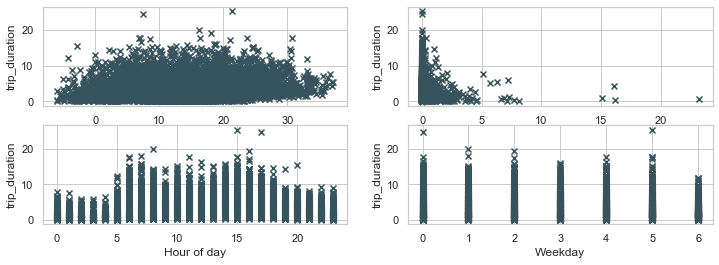

In [56]:
visualize_features(frb_hourly, "trip_duration")

- Bremen

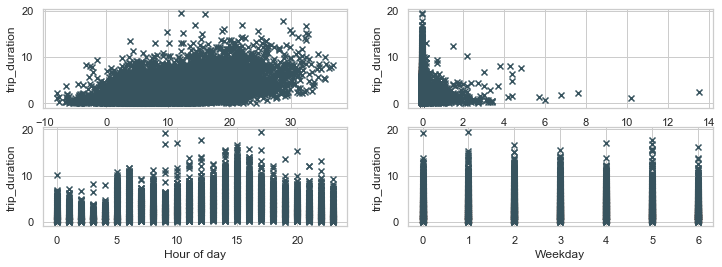

In [57]:
visualize_features(brm_hourly, "trip_duration")

Now we split the frb and brm data into a train- and a test-set

In [58]:
frb_features = frb_hourly[["temperature","hour", "weekday", "precipitation"]]
frb_predictor = frb_hourly["trip_duration"]

frb_split = train_test_split(frb_features, frb_predictor, test_size=0.2, random_state=0)

brm_features = brm_hourly[["temperature","hour", "weekday", "precipitation"]]
brm_predictor = brm_hourly["trip_duration"]

brm_split = train_test_split(brm_features, brm_predictor, test_size=0.2, random_state=0)

### Linear Regression
- Freiburg

In [59]:
out = linear_regression(frb_split)
print("R^2:" ,out.r2)

R^2: 0.07583061660802193


- Bremen

In [60]:
out = linear_regression(brm_split)
print("R^2: ",out.r2)

R^2:  0.24959126597479342


As we can see the $$R^2$$ of Freiburg is much lower than in Bremen since
we miss 5 months of data from January to May 2019.

### Polynomial regression

In order to determinate the best degree for a polynomial regression we plotted the $$MSE$$ and the $$R^2$$ value for multiple degrees
- Freiburg

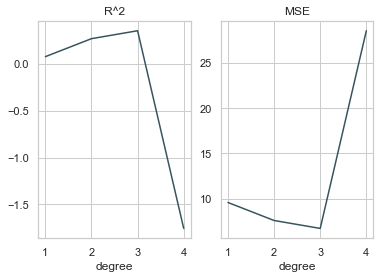

Max R^2:  0.3522706355246785
Min mse:  6.71313004162425


In [61]:
test_degree(1, 5, 1, frb_split)

- Bremen

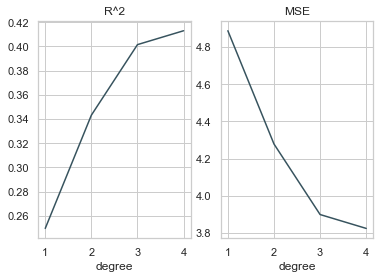

Max R^2:  0.4129953387844909
Min mse:  3.823734573816318


In [62]:
test_degree(1, 5, 1, brm_split)

To ensure that multiple features actually increase the *r2* value we plotted a graph with degree=3
- Freiburg


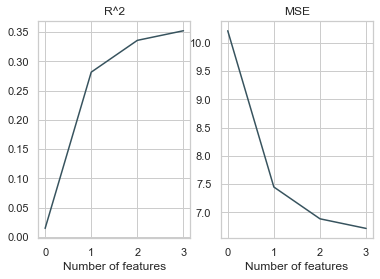

Max R^2:  0.3522706355246785
Min mse:  6.71313004162425


In [84]:
test_amount_features(frb_hourly, "trip_duration")

- Bremen

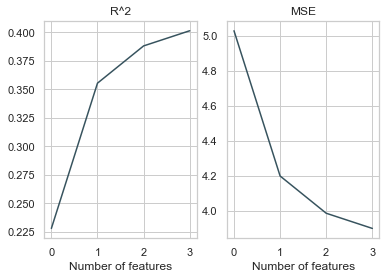

Max R^2:  0.4015226745911403
Min mse:  3.898467238867156


In [85]:
test_amount_features(brm_hourly, "trip_duration")


### Ridge regression
In the following the optimal alpha will be determined for the ridge and the lasso regression
- Freiburg

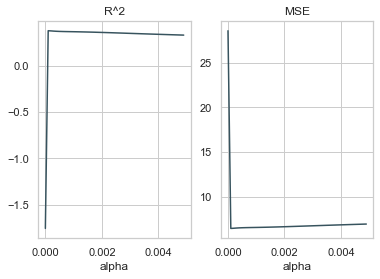

Best alpha:  0.0001
Max R^2:  0.3748826057288761
Min mse:  6.478777386328052


In [65]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, frb_split)

- Bremen

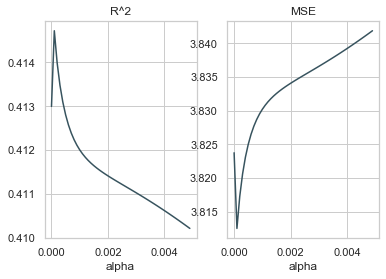

Best alpha:  0.0001
Max R^2:  0.4147218509977282
Min mse:  3.812488113816833


In [66]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, brm_split)


### Lasso regression
- Freiburg

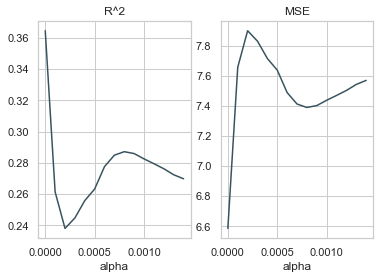

Best alpha:  0
Max R^2:  0.36460799025073165
Min mse:  6.585264499025714


In [67]:
test_regression_alpha(0, 0.0015, 0.0001, lasso_regression, frb_split)

- Bremen

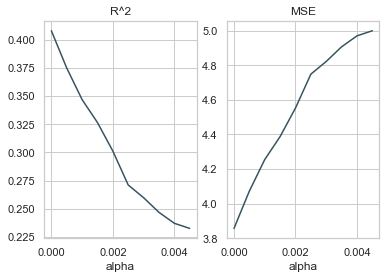

Best alpha:  0
Max R^2:  0.40790014301556476
Min mse:  3.856924559363729


In [68]:
test_regression_alpha(0, 0.005, 0.0005, lasso_regression, brm_split)

### Plot the Regression
- Freiburg

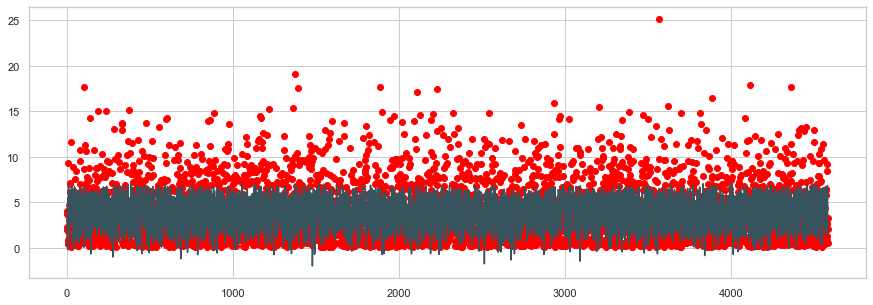

In [69]:
out = polynomial_regression(frb_split, 3)

plt.figure(figsize=(15, 5))
plt.scatter(range(0,len(out.y_train)), out.y_train, c="red")
plt.plot(range(0,len(out.y_train)), out.y_pred)

- Bremen

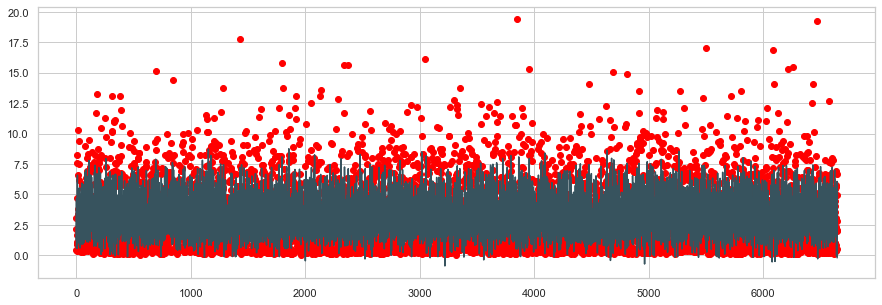

In [70]:
out = polynomial_regression(brm_split, 3)

plt.figure(figsize=(15, 5))
plt.scatter(range(0,len(out.y_train)), out.y_train, c="red")
plt.plot(range(0,len(out.y_train)), out.y_pred)


## Prediction of amount bikes

### Visualization of the four features for the regression
(Temperature, Precipitation, Hour, Weekday)
- Freiburg:

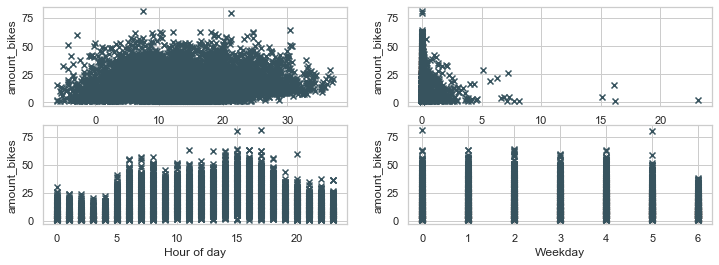

In [87]:
visualize_features(frb_hourly, "amount_bikes")

- Bremen

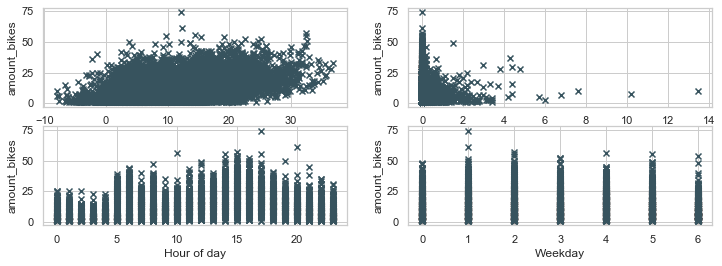

In [74]:
visualize_features(brm_hourly, "amount_bikes")

Now we split the frb and brm data into a train- and a test-set

In [88]:
frb_features = frb_hourly[["temperature","hour", "weekday", "precipitation"]]
frb_predictor = frb_hourly["amount_bikes"]

frb_split = train_test_split(frb_features, frb_predictor, test_size=0.2, random_state=0)

brm_features = brm_hourly[["temperature","hour", "weekday", "precipitation"]]
brm_predictor = brm_hourly["amount_bikes"]

brm_split = train_test_split(brm_features, brm_predictor, test_size=0.2, random_state=0)

### Linear Regression
- Freiburg

In [89]:
out = linear_regression(frb_split)
print("R^2:" ,out.r2)

R^2: 0.08618688139865804


- Bremen

In [77]:
out = linear_regression(brm_split)
print("R^2: ",out.r2)

R^2:  0.2212013227711126


As we can see the $$R^2$$ of Freiburg is much lower than in Bremen since
we miss 5 months of data from January to May 2019.

### Polynomial regression

In order to determinate the best degree for a polynomial regression we plotted the $$MSE$$ and the $$R^2$$ value for multiple degrees
- Freiburg

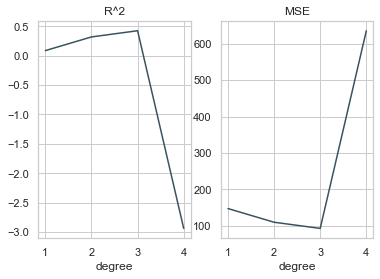

Max R^2:  0.42390363225982497
Min mse:  92.9551261412525


In [78]:
test_degree(1, 5, 1, frb_split)

- Bremen

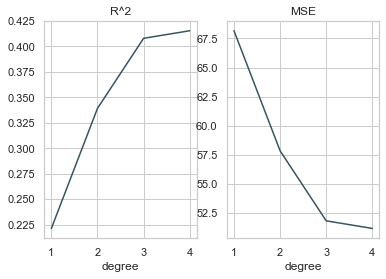

Max R^2:  0.4154478127772999
Min mse:  51.161545732989296


In [79]:
test_degree(1, 5, 1, brm_split)

To ensure that multiple features actually increase the *r2* value we plotted a graph with degree=3
- Freiburg


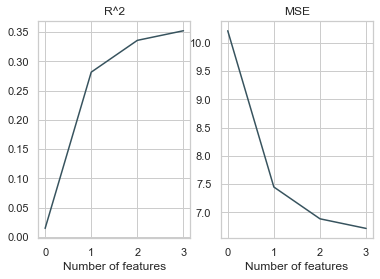

Max R^2:  0.3522706355246785
Min mse:  6.71313004162425


In [90]:
test_amount_features(frb_hourly, "trip_duration")

- Bremen

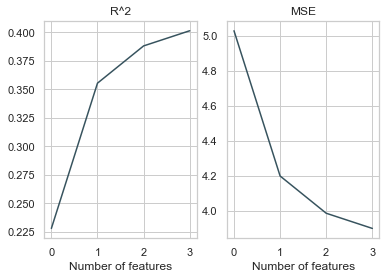

Max R^2:  0.4015226745911403
Min mse:  3.898467238867156


In [91]:
test_amount_features(brm_hourly, "trip_duration")


### Ridge regression
In the following the optimal alpha will be determined for the ridge and the lasso regression
- Freiburg

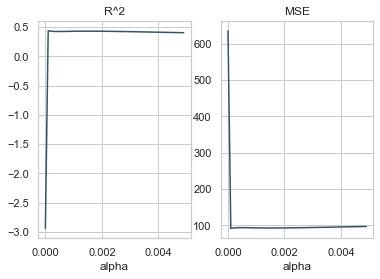

Best alpha:  0.0001
Max R^2:  0.43474277972016484
Min mse:  91.2061924977515


In [92]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, frb_split)

- Bremen

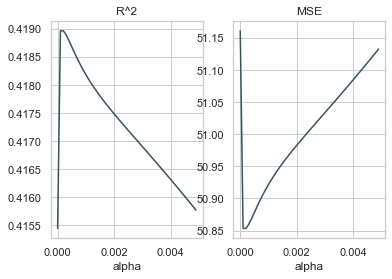

Best alpha:  0.0002
Max R^2:  0.4189698406971538
Min mse:  50.85328858087668


In [93]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, brm_split)


### Lasso regression
- Freiburg

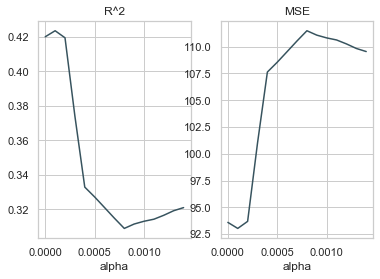

Best alpha:  0.0001
Max R^2:  0.42341855253049276
Min mse:  93.03339542041064


In [94]:
test_regression_alpha(0, 0.0015, 0.0001, lasso_regression, frb_split)

- Bremen

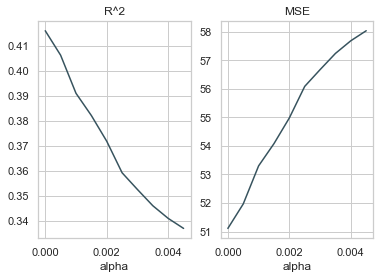

Best alpha:  0
Max R^2:  0.4160120170572592
Min mse:  51.11216508964753


In [95]:
test_regression_alpha(0, 0.005, 0.0005, lasso_regression, brm_split)

### Plot the Regression
- Freiburg

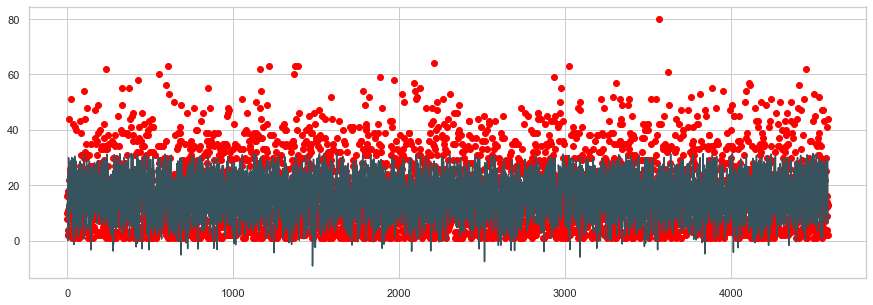

In [96]:
out = polynomial_regression(frb_split, 3)

plt.figure(figsize=(15, 5))
plt.scatter(range(0,len(out.y_train)), out.y_train, c="red")
plt.plot(range(0,len(out.y_train)), out.y_pred)

- Bremen

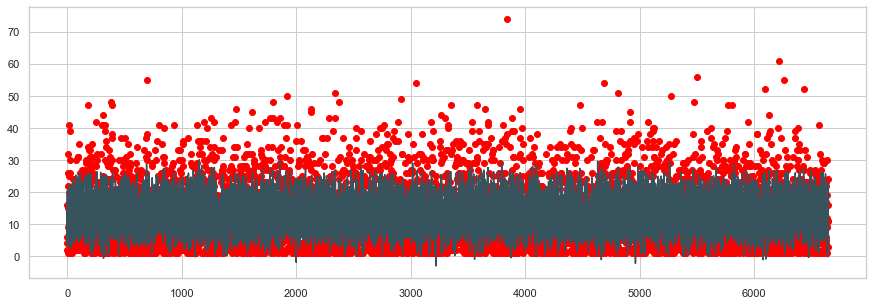

In [97]:
out = polynomial_regression(brm_split, 3)

plt.figure(figsize=(15, 5))
plt.scatter(range(0,len(out.y_train)), out.y_train, c="red")
plt.plot(range(0,len(out.y_train)), out.y_pred)




















Split the data set into traing(60%), validation(20%), test(20%) setst to prevent leakage.

In [ ]:
x_train, x_validate, x_test = np.split(brm_hourly['temperature'].sample(frac=1), [int(.6*len(brm_hourly['temperature'])), int(.8*len(brm_hourly['temperature']))])
y_train, y_validate, y_test = np.split(brm_hourly['trip_duration'].sample(frac=1), [int(.6*len(brm_hourly['trip_duration'])), int(.8*len(brm_hourly['trip_duration']))])

In [ ]:
plt.scatter(x_train, y_train, label = "Training Data", color = "r", alpha =.7)
plt.scatter(x_test, y_test, label = "Test Data", color = "b", alpha =.7)
plt.scatter(x_validate, y_validate, label = "Validation Data", color = "g", alpha =.7)
plt.legend()
plt.title("Train_Test_Validate Split")
plt.show()

In [ ]:
#Create linear model and train it 
lr = LinearRegression()
lr.fit(x_train.values.reshape(-1, 1), y_train.values)

In [ ]:
# Use model to predict on test data
prediction = lr.predict(x_test.values.reshape(-1, 1))

# Plot prediction line against actual test data 
plt.plot(x_test, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_test, y_test, label='Actual test data', color = 'b', alpha=.7)
plt.legend()
plt.show()

The best score that we could achieve for a model is 1.0. 
~Soo our linear model is not that great...

In [ ]:
# Plot prediction line against actual test data 
prediction = lr.predict(x_validate.values.reshape(-1, 1))
plt.plot(x_validate, prediction, label='Linear Regression', color = 'r')
plt.scatter(x_validate, y_validate, label='Actual test data', color = 'g', alpha=.7)
plt.legend()
plt.show()

In [ ]:
# Score the model 
lr.score(x_validate.values.reshape(-1, 1), y_validate.values)

In [ ]:
y_true = y_validate
y_pred = lr.predict(x_validate.values.reshape((-1,1)))

In [ ]:
print("Mean Squared Error:",mean_squared_error(y_pred, y_true))
print("Root Mean Squared Error:",mean_squared_error(y_pred, y_true)**0.5)
print("Coefficient of determination:",r2_score(y_true, y_pred))

### Polynomial  regression

def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

In [ ]:
def plot_regression_poly(X,Y,d):
    
    # initialize PolynomialFeatures
    poly_reg = PolynomialFeatures (degree = d)
    
    # Polynomial transformation
    x_poly = poly_reg.fit_transform(X.reshape(-1,1))
    lin_reg_Poly = LinearRegression()
    
    # Fitting linear regression to polynomial features
    lin_reg_Poly.fit(x_poly, Y)
    model_pred = lin_reg_Poly.predict(x_poly)
    
    # Plotting the regression line and the data (we have to transform the inputs as well!)
    x_fit = np.arange(X.min(),X.max() ,1)[:, np.newaxis]
    y_pred = lin_reg_Poly.predict(poly_reg.fit_transform(x_fit.reshape(-1,1)))
    
    plt.figure(figsize = (8,6))
    plt.scatter(X,Y,marker="o", c='C2')
    ylim = plt.ylim()
    plt.plot(x_fit,y_pred, c='C1')
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Demand (Min)")
    plt.xlim([X.min()-2,X.max()+2]) # leave some space before and after limits
    plt.ylim(ylim)
    print ('The R^2 for quadratic curve is: ',r2_score(Y, model_pred))
    print(lin_reg_Poly.coef_) 

In [ ]:
xp = x_train.values

yp = y_train 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
xp = x_test.values

yp = y_test 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
xp = x_validate.values

yp = y_validate 

plot_regression_poly(X = xp, Y = yp, d = 4)

In [ ]:
plot_regression_poly

### Idea

Split dataset into train_test_validate sets not for every hour individually but rather hourly.